In [31]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

day = 67
v_lab = LabFuncs.LabVelocitySimple(day)

# Load VL2 data
vmax = 750.0
nbins = 50
h = zeros(shape=(200,nbins))
fdir = '../../../vl2data/bubbles/'
for i in range(0,200):
    VL2 = loadtxt(fdir+'bubble_1kpc_200_'+str(i+1)+'.dat')+v_lab
    vv = sqrt(sum(VL2**2.0,1))
    H = histogram(vv,nbins,range=(0.0,vmax),normed=True)
    h[i,:] = H[0]
vbins = H[1]

In [35]:
# v range
n = 300
v = linspace(0.01,vmax,n)

# Halo params
v0 = 180.0
v_esc = 516.0
sig_beta = SHMpp.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)

# v range
n = 300
v = linspace(0.01,vmax,n)

v_esc = amax(vv)
sig_iso = array([1.0,1.0,1.0])*120
fv_Iso_gal = SpeedDist_Triaxial(v,day,sig_iso,GalFrame=True) # Galactic frame Halo

# Load shards
df = pandas.read_csv('../data/FitShards.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
Psun[Psun==inf] = 0.0
pops[1] = 30.0
weights = pops#*norm.pdf(Psun,loc=0.0,scale=1.0)/norm.pdf(0.0,loc=0.0,scale=1.0)
weights /= sum(weights)

# Smooth Speed distributions
fv_Iso = SpeedDist_Triaxial(v,day,sig_iso) # Galactic frame Halo
fv_Saus = SpeedDist_Triaxial(v,day,sig_beta) # Galactic frame Sausage
fv = zeros(shape=(nshards,n))
for i in range(0,nshards):
    v_s = velocities[i,:]
    sig_s = dispersions[i,:]
    fv[i,:] = weights[i]*SpeedDist_Triaxial(v,day,sig_s,v_shift=v_s,EscapeSpeed=False)

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/ciaranohare/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



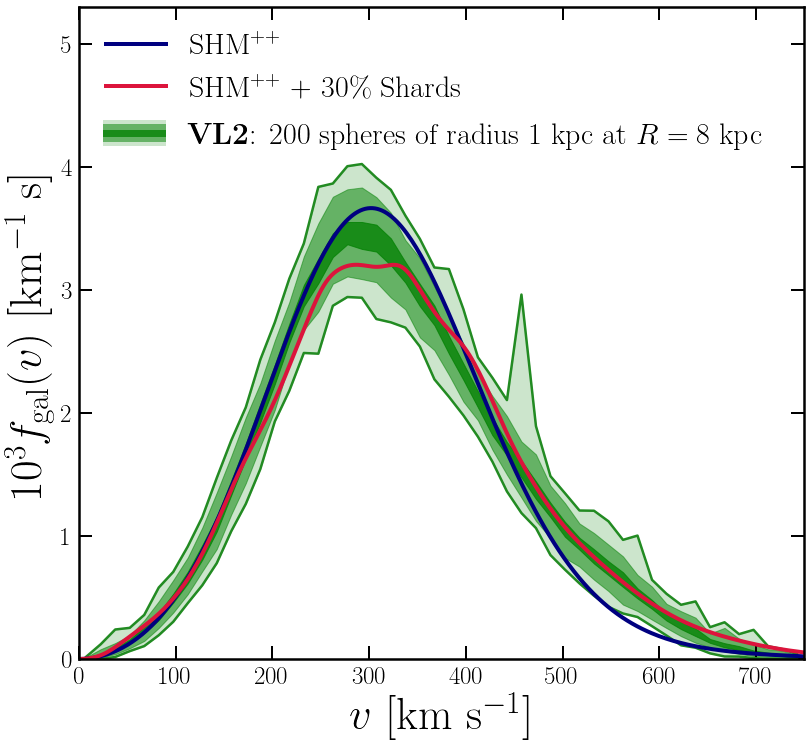

In [205]:
# Figure setup
xlab = r"$v$ [km s$^{-1}$]"
ylab = r"$10^3 f_{\rm gal}(v)$ [km$^{-1}$ s]"
fig,ax = MySquarePlot(xlab,ylab)

nhbins = 50
HH = zeros(shape=(nbins,nhbins))
h95 = zeros(shape=(nbins,2))
h68 = zeros(shape=(nbins,2))
htot = zeros(shape=(nbins,2))
hmin = 1.0/(1.0*nbins)
for i in range(0,nbins):
    H = histogram(h[:,i],nhbins,range=(0.0,5.0e-3))
    HH[i,:] = H[0]/(1.0*amax(H[0]))
    
    fvals = (sort(h[:,i]))
    hvals = cumsum(fvals)
    hvals = hvals/hvals[-1]
    htot[i,0] = fvals[hvals>0.0][0]
    h95[i,0] = fvals[hvals>0.05][0]
    h68[i,0] = fvals[hvals>0.32][0]
    h68[i,1]= fvals[hvals>0.68][0]
    h95[i,1] = fvals[hvals>0.95][0]
    htot[i,1] = fvals[hvals>=1.0][0]

hbins = H[1]

vc = vbins[0:-1]+vbins[1]/2.0

#plt.contourf(vc,1e3*(hbins[0:-1]+hbins[1]/2.0),HH.T,10,cmap=cm.Greens)
plt.fill_between(vc,1e3*htot[:,1],y2=1e3*htot[:,0],color='Green',alpha=0.2)
plt.fill_between(vc,1e3*h95[:,1],y2=1e3*h95[:,0],color='Green',alpha=0.5)
plt.fill_between(vc,1e3*h68[:,1],y2=1e3*h68[:,0],color='Green',alpha=0.75)
plt.fill_between([25,90],[4.38,4.38],y2=[4.17,4.17],color='Green',alpha=0.2,lw=0)
plt.fill_between([25,90],[4.35,4.35],y2=[4.2,4.2],color='Green',alpha=0.5,lw=0)
plt.fill_between([25,90],[4.3,4.3],y2=[4.24,4.24],color='Green',alpha=0.75,lw=0)

plt.plot(vc,1e3*amax(h,0),lw=2.5,color='ForestGreen')
plt.plot(vc,1e3*amin(h,0),lw=2.5,color='ForestGreen')

xi = 0.3
eta = 0.2
fv0 = (1-eta)*fv_Iso+eta*fv_Saus
fv_tot = (1-xi)*fv0+xi*sum(fv,0)
plt.plot(v,1e3*fv0,'-',lw=4.0,color='Navy',label="SHM$^{++}$")
plt.plot(v,1e3*fv_tot,'-',lw=4.0,color='Crimson',label="SHM$^{++}$ + 30\% Shards")
plt.gcf().text(0.24,0.72,r'{\bf VL2}: 200 spheres of radius 1 kpc at $R=8$ kpc',fontsize=30)
leg = plt.legend(loc=2,frameon=False,fontsize=30)

# Plot fiddling
ax.set_xlim(left=0,right=vmax)
ax.set_ylim(bottom=0,top=5.3)


plt.show()
pltname = 'Shards_fv_wVL2'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')